# Preliminaries + Installs

These instructions are for Python 3.10
### Install Ollama
* `cd /tmp`
* `curl -fsSL https://ollama.com/install.sh | sh`
* Test, Optional (2GB download): `ollama run llama3.2`, Type `/bye` when done
### Install Langchain
* `python3.10 -m pip install langchain langchain_community langchain_chroma langchain_ollama llama-index-legacy pypdf langchain-unstructured "unstructured[pdf]" --user`
### Install SQLite ( >= 3.35.0 required, This will install 3.46 )
* `sudo apt install libreadline-dev python3.10-dev`
* `wget https://sqlite.org/2024/sqlite-autoconf-3460100.tar.gz`
* `tar -xvf sqlite-autoconf-3460100.tar.gz && cd sqlite-autoconf-3460100`
* `./configure`
* `make`
* `sudo make install`
* `python3.10 -m pip uninstall pysqlite3`
* `python3.10 -m pip install pysqlite3-binary --user`

# Build/Expand Document Database + Embeddings

## State

In [1]:
from os import environ, path
import time, sys, json
now = time.time

environ["_RAG_STATE_PATH"] = "data/state.json"

RAGstate = {
    'libDocs' : list(),
    'pages'   : dict(),
}

def save_state():
    global RAGstate
    with open( environ["_RAG_STATE_PATH"], 'w' ) as f:
        json.dump( RAGstate, f, indent = 4 )

def load_state():
    global RAGstate
    try:
        with open( environ["_RAG_STATE_PATH"], 'r' ) as f:
            RAGstate = json.load(f)
    except FileNotFoundError as e:
        print( f"Could not load {environ['_RAG_STATE_PATH']}!\n{e}" )

load_state()

## Helper Functions

In [2]:
from uuid import uuid4

def safe_str( data ):
    """Filters out invalid UTF-8 characters from a string."""
    return str( data ).encode( 'utf-8', 'ignore' ).decode( 'utf-8' )

def gen_ID():
    """ Generate a unique ID """
    return safe_str( uuid4() )

def pull_ollama_model( modelStr ):
    """ Pull a named model from Ollama and store it wherever """
    print( f"About to save '{modelStr}'.\nThis will spew a lot of text on the first run..." )
    os.system( f"ollama pull {modelStr}" )



## Copy PDFs

In [3]:
from os import path, makedirs
from aa_scrape_PDF import copy_pdfs

environ["_RAG_PDF_SOURCE"] = "/media/james/FILEPILE/$_Robust_Planning/Literature/References/storage"
environ["_RAG_PDF_DESTIN"] = "data/input/pdf"
environ["_RAG_PDF_ERROR"]  = "data/input/BAD_PDF"
environ["_RAG_PAGE_DESTN"] = "data/input/pages"
environ["_RAG_VERBOSE"]    =    ""
environ["_RAG_DOC_ADD"]    =   "200" #"25" #"200"
environ["_RAG_DOC_LIMIT"]  = "10000"
environ["_RAG_DOC_DBASE"]  = "lit_pdf"

if not path.exists( environ["_RAG_PDF_ERROR"] ):
    makedirs( environ["_RAG_PDF_ERROR"] )


## Determine if more docs will be loaded this session

In [4]:
%%capture
# Loading the vector store sometimes spews warnings

__import__('pysqlite3')
sys.modules['sqlite3'] = sys.modules.pop( 'pysqlite3' )
import chromadb
from langchain_chroma import Chroma


persistent_client = chromadb.PersistentClient();
collection        = persistent_client.get_or_create_collection( environ["_RAG_DOC_DBASE"] );

environ["_RAG_DOCDB_COUNT" ] = str( collection.count() )
environ["_RAG_DOCDB_REMAIN"] = str( min( int(environ["_RAG_DOC_LIMIT"])-len(RAGstate['libDocs']), int(environ["_RAG_DOC_ADD"]) ) )


In [5]:
print( f"{environ['_RAG_DOCDB_COUNT' ]} vector records exist!" )
print( f"{environ['_RAG_DOCDB_REMAIN']} files will be copied!" )

copy_pdfs()

....

## Load PDFs by page chunks

### https://python.langchain.com/docs/how_to/document_loader_pdf/

* `python3.10 -m pip install pypdf langchain-unstructured "unstructured[pdf]" --user`
* `apt install tesseract-ocr`

In [6]:

def collect_unique_metadata_by_key( key ):
    """ Return a list of unqiue metadata values from the vector store by `key` """
    global collection
    unique = set()
    for result in collection.get()['metadatas']:
       if key in result:
           unique.add( result[key] )
    return list( unique )


def find_unread_PDFs_at_input():
    """ Return a list of PDF paths that do NOT have pages in the vector store """
    global RAGstate
    inputPDFs = collect_unique_metadata_by_key( 'source' )
    rtnPaths  = list()
    for pdf in inputPDFs:
        if pdf not in RAGstate['libDocs']:
            rtnPaths.append( pdf )
    return rtnPaths
            

In [7]:
import os, shutil
from collections import deque
from langchain_community.document_loaders import PyPDFLoader

pages       = None
pdfs_drct   = environ["_RAG_PDF_DESTIN"]
eror_drct   = environ["_RAG_PDF_ERROR" ]
fNames      = [item for item in os.listdir( pdfs_drct ) if (str( item ).split('.')[-1].lower() == 'pdf')]

# needToParse = find_unread_PDFs_at_input()
# fNames.extend( needToParse )

print( f"There are {len(fNames)} candidate files!" )

if len( fNames ) > 0:
    bgn       = now()
    pages     = deque() # Fast append
    lastLn    = 0
    
    for i, fNam in enumerate( fNames ):
        file_path = str( path.join( pdfs_drct, fNam ) )
        if file_path not in RAGstate['libDocs']:
            try:
                loader    = PyPDFLoader( file_path )
                async for page in loader.alazy_load():
                    pages.append( page )
                print( f"{i+1}:{len(pages)-lastLn}:{len(pages)}", end = ', ', flush = True )
                lastLn = len(pages)
            except Exception as e:
                print( f"ERROR:{e}", end = ', ', flush = True )
                try:
                    shutil.move( file_path, path.join( eror_drct, fNam ) )
                except Exception as e:
                    print( f"FAILED to move {file_path} --to-> {path.join( eror_drct, fNam )}" )
            except asyncio.CancelledError as e:
                print( f"Load operation cancelled by user" )
                raise e
                    
            
    print()
    pages = list( pages )
    print( f"Read {len(pages)} pages in {(now()-bgn)/60.0:.2f} minutes!" )

save_state()

There are 325 candidate files!
1:22:22, 2:18:40, 7:17:57, 8:14:71, 11:19:90, 12:7:97, 13:9:106, 17:30:136, 18:15:151, 19:15:166, 20:28:194, 21:6:200, 22:12:212, 24:12:224, 26:23:247, 27:13:260, 28:23:283, 29:4:287, 30:28:315, 31:12:327, 33:20:347, 34:22:369, 35:14:383, 39:19:402, 40:15:417, 41:11:428, 46:4:432, 48:12:444, 49:8:452, 50:8:460, 51:8:468, 53:16:484, 54:68:552, 56:1:553, 57:38:591, 59:18:609, 62:33:642, 63:15:657, 68:21:678, 69:7:685, 70:7:692, 72:14:706, 73:10:716, 75:3:719, 76:12:731, 77:17:748, 78:9:757, 80:7:764, 82:2:766, 83:6:772, 84:179:951, 86:40:991, 88:12:1003, 89:6:1009, 92:8:1017, 93:13:1030, 95:12:1042, 96:15:1057, 98:9:1066, 100:6:1072, 102:48:1120, 103:6:1126, 105:16:1142, 106:13:1155, 108:9:1164, 109:5:1169, 111:7:1176, 112:20:1196, 114:12:1208, 115:5:1213, 116:12:1225, 118:6:1231, 119:7:1238, 120:10:1248, 121:31:1279, 123:6:1285, 124:6:1291, 125:7:1298, 128:29:1327, 129:16:1343, 131:5:1348, 132:6:1354, 135:8:1362, 136:10:1372, 137:6:1378, 139:16:1394, 140:1

In [8]:
# print(f"{pages[0].metadata}\n")
# print(pages[0].page_content)

## Load the text embedding model

In [9]:
import sys, os, time
now = time.time

from langchain_ollama import OllamaEmbeddings

pull_ollama_model( "all-minilm" )

local_embeddings = OllamaEmbeddings( model = "all-minilm" )

About to save 'all-minilm'.
This will spew a lot of text on the first run...


pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠸ pulling manifest ⠸ pulling manifest ⠴ pulling manifest 
pulling 797b70c4edf8... 100% ▕████████████████▏  45 MB                         
pulling c71d239df917... 100% ▕████████████████▏  11 KB                         
pulling 85011998c600... 100% ▕████████████████▏   16 B                         
pulling 548455b72658... 100% ▕████████████████▏  407 B                         
verifying sha256 digest 
writing manifest 
success 


## Populate document vector database (of pages)

In [10]:
import base64
import io

import fitz, pymupdf
from PIL import Image


def pdf_page_to_base64( pdf_path: str, page_number: int ):
    zoom_x       = 1.5  # horizontal zoom
    zoom_y       = 1.5  # vertical zoom
    mat          = pymupdf.Matrix( zoom_x, zoom_y )
    pdf_document = fitz.open( pdf_path )
    page         = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix          = page.get_pixmap( matrix = mat )
    img          = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    buffer       = io.BytesIO()
    
    img.save( buffer, format="PNG" )

    return base64.b64encode( buffer.getvalue() ).decode("utf-8")

In [11]:
import pickle

if not path.exists( environ["_RAG_PAGE_DESTN"] ):
    makedirs( environ["_RAG_PAGE_DESTN"] )


def get_page_meta_key( source, page ):
    """ Generate a (probably not) unique page key with useful data that can also be used for sorting """
    return str( source ).split('/')[-1].replace(' ','') + '_' + str( page )


if int(environ["_RAG_DOCDB_REMAIN"]) > 0:
    bgn = now()
    docIDs  = [str( gen_ID() ) for _ in range( len(pages) )]
    dcmnts  = [str( pg.page_content ) for pg in pages]
    metaDt  = list()
    d       = 50
    readSet = set([])

    for i, pg in enumerate( pages ):

        id_i  = docIDs[i]
        
        # Save Text Metadata #
        mDct = pg.metadata
        mDct['metakey'] = get_page_meta_key( pg.metadata['source'], pg.metadata['page'] )
        mDct['docID'  ] = id_i
        metaDt.append( mDct )

        src = pg.metadata['source']

        #  vv- Quick Search -vv     vvvvv--- Long Search ---vvvvvvvv
        if (src not in readSet) and (src not in RAGstate['libDocs']):
            readSet.add( src )
            RAGstate['libDocs'].append( src )

        # Save PDF Page image #
        try:
            pkl_i = path.join( environ["_RAG_PAGE_DESTN"], f"{id_i}.pkl" )
            pgPic = pdf_page_to_base64( pg.metadata['source'], pg.metadata['page'] )
            
            with open( pkl_i, 'wb' ) as f:
                RAGstate['pages'][ id_i ] = str( pkl_i )
                pickle.dump( pgPic, f )
        except Exception as e:
            print( f"Could NOT save image ID {id_i}!, {e}" )

        if (i % d == 0):
            print( '.', end='', flush = True )
    print()
    
    collection.add(
        ids       = docIDs, 
        metadatas = metaDt,
        documents = dcmnts
    )
    print( f"Added {len(dcmnts)} documents in {(now()-bgn)/60.0:.2f} minutes!" )

save_state()



............................................................MuPDF error: syntax error: could not parse color space (238 0 R)

MuPDF error: syntax error: could not parse color space (345 0 R)

...............
Added 3744 documents in 7.86 minutes!


# Create vector store

In [12]:
bgn = now()
vector_store_from_client = Chroma(
    client             = persistent_client,
    collection_name    = environ["_RAG_DOC_DBASE"],
    embedding_function = local_embeddings,
)
print( f"Built vector store in {(now()-bgn):.4f} seconds!" )

Built vector store in 0.0024 seconds!


# Load VLM

In [13]:
from langchain_ollama import ChatOllama

pull_ollama_model( "llava" )

llm = ChatOllama(
    model="llava",
)

About to save 'llava'.
This will spew a lot of text on the first run...


pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest 
pulling 170370233dd5... 100% ▕████████████████▏ 4.1 GB                         
pulling 72d6f08a42f6... 100% ▕████████████████▏ 624 MB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         
pulling c43332387573... 100% ▕████████████████▏   67 B                         
pulling ed11eda7790d... 100% ▕████████████████▏   30 B                         
pulling 7c658f9561e5... 100% ▕████████████████▏  564 B                         
verifying sha256 digest 
writing manifest 
success 


# Setup LangChain

In [14]:
os.environ["LANGCHAIN_TRACING_V1"] = "false"
os.environ["LANGCHAIN_TRACING_V2"] = "false"

# from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

# Retrieve and generate using the relevant snippets of the blog.
retriever = vector_store_from_client.as_retriever()

# Instantiation using from_template (recommended)
prompt1 = PromptTemplate( 
    template = """You are an expert assistant capable of interpreting textual information to provide accurate 
                  and detailed responses. You are provided with the following data:
                  Context: {docData}
                  Text query: {userQuery}
                  Use your understanding of the provided context to generate a response to based on 
                  relevant, up-to-date information. Ensure your answer is factually accurate, detailed, and leverages academic 
                  sources where possible. If additional context is required for clarification, request it from the user.""",
    input_variables = ["docData","userQuery"],
)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain1 = (
    { "docData": retriever | format_docs, 
      "userQuery": RunnablePassthrough()}
    | prompt1
    | llm
    | StrOutputParser()
)

In [15]:
def ask_with_sources( q ):
    retrieved_docs = retriever.invoke( q )
    generated_ansr = rag_chain1.invoke( q )
    return {
        'response' : generated_ansr,
        'sources'  : retrieved_docs,
    }

In [16]:
def fetch_local_pages( sourceList ):
    global RAGstate
    rtnObjs = list()
    for source in sourceList:
        if source.metadata['docID'] in RAGstate['pages']:
            pklPath = RAGstate['pages'][ source.metadata['docID'] ]
            with open( pklPath, 'rb' ) as f:
                obj_i = pickle.load( f )
                rtnObjs.append( obj_i )
        else:
            print( f"No page with ID {source.metadata['docID']}" )
    return rtnObjs

In [17]:
from pprint import pprint
from IPython.display import Image as IPImage
from IPython.display import display
from langchain_core.messages import HumanMessage

def deep_doc_ask( q ):
    bgn = now()
    res = ask_with_sources( q ) 
    pprint( res['response'] )
    print( f"Initial LLM summary took {now()-bgn:.2f} seconds to process!" )
    
    pag = fetch_local_pages( res['sources'] )

    for p in pag:
        display( IPImage( data = base64.b64decode( p ) ) )
        message = HumanMessage(
            content=[
                {"type": "text", "text": q},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{p}"},
                },
            ],
        )
        bgn = now()
        response = llm.invoke( [message] )
        print( f"LLM query took {now()-bgn:.2f} seconds to process!" )
        pprint( response.content )

(' An efficient motion planning algorithm for robotic manipulation is "Motion '
 'planning with sequential convex optimization and convex collision checking," '
 'which was published in The International Journal of Robotics Research in '
 '2014. This algorithm was developed by a team of researchers at UC Berkeley, '
 'led by John Schulman and Pieter Abbeel.\n'
 '\n'
 'The method uses sequential convex optimization (SCO) to generate a sequence '
 'of collision-free poses for the robot manipulator. The key idea is to '
 'formulate the motion planning problem as an optimization problem, where the '
 'objective is to minimize the time taken by the robot to reach its target '
 'pose while avoiding collisions with obstacles in the environment.\n'
 '\n'
 'The algorithm works by first approximating the workspace and obstacles as a '
 'set of convex polyhedra. It then uses SCO to find a path through this '
 'approximation that minimizes the objective function. The resulting path is '
 'collisio

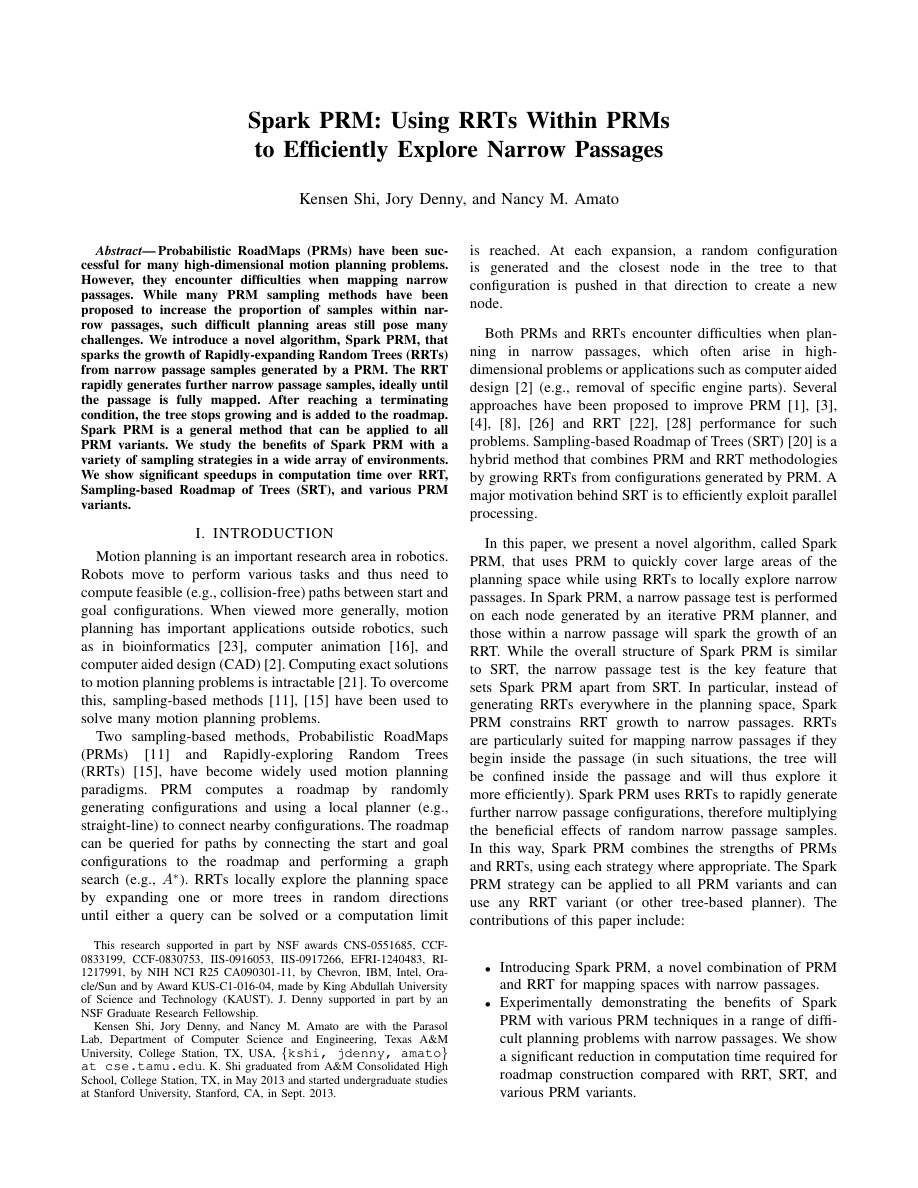

LLM query took 17.73 seconds to process!
(' The image shows a scientific paper or article, as indicated by the layout '
 'and text. The title of the article is "Spark: A Learning-Based Pipeline for '
 'Robotic Manipulation." Below the title, there are two authors listed along '
 'with their affiliations, which include "Carnegie Mellon University" and '
 'references to the work being presented.\n'
 '\n'
 'The paper appears to discuss a new method or system called "Spark," which is '
 'designed to enhance robotic manipulation capabilities. It mentions that the '
 'Spark pipeline integrates various learning-based techniques into a single, '
 'efficient process for solving problems in this domain.\n'
 '\n'
 'The text within the image includes technical terms such as "learning-based," '
 '"robotic manipulation," and "pipeline," suggesting that the article is '
 'discussing advanced methods in robotics, possibly involving machine learning '
 'or artificial intelligence. However, due to the l

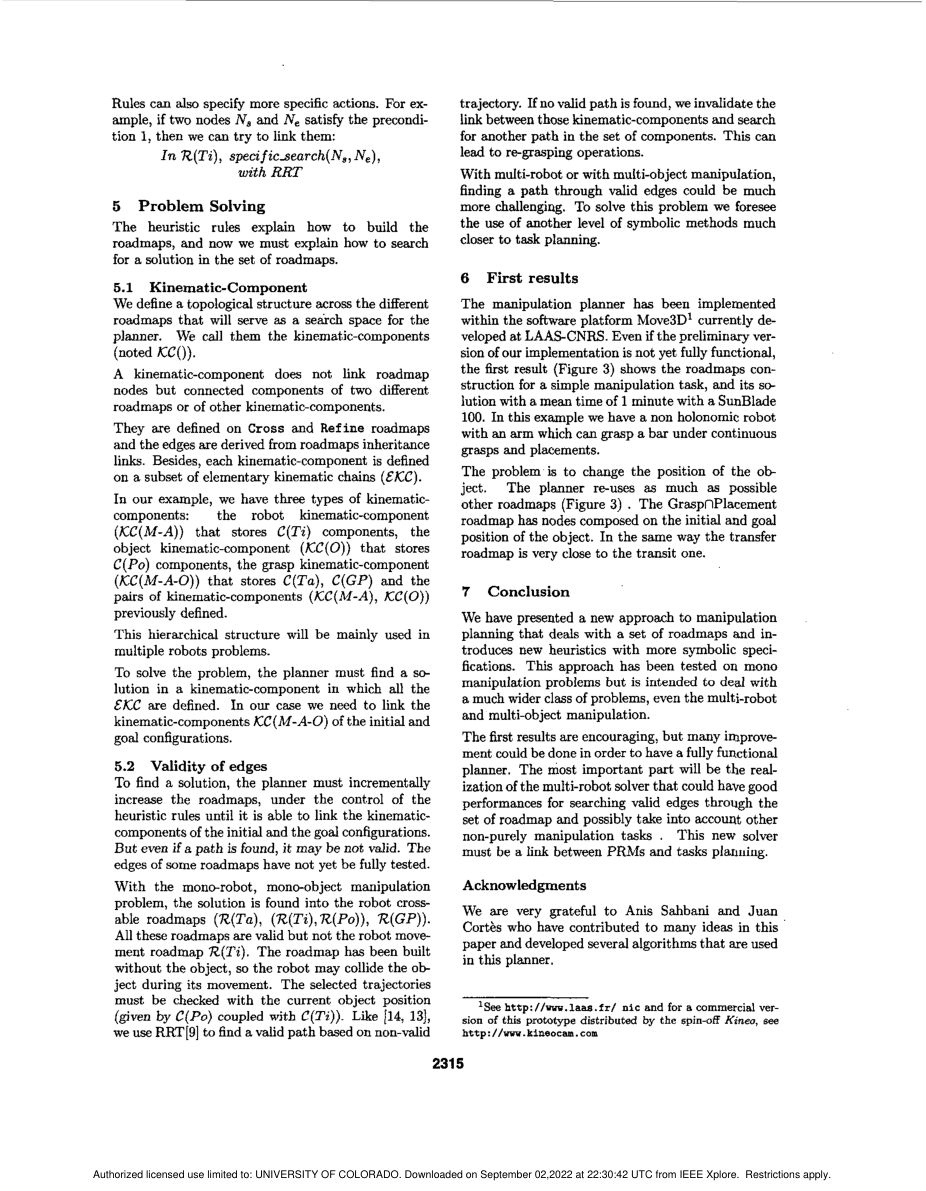

LLM query took 36.12 seconds to process!
(" The image you've shared appears to be a page from a document, possibly an "
 'academic paper or article. However, the resolution of the image is too low '
 'for me to provide specific details about the text on the page, including any '
 'information related to the "efficient motion planning algorithm" mentioned '
 'in your question.\n'
 '\n'
 'In general, designing an efficient motion planning algorithm for robotic '
 'manipulation involves several steps and considerations:\n'
 '\n'
 '1. **Problem Definition**: Define the problem of motion planning with all '
 "its constraints and requirements. This includes specifying the robot's "
 'capabilities, the task to be performed, the environment in which the task '
 'takes place, and any other relevant information.\n'
 '\n'
 '2. **Representation of State Space**: Create a representation of the state '
 'space that the robot can occupy. This could involve representing the '
 'position, orientation, 

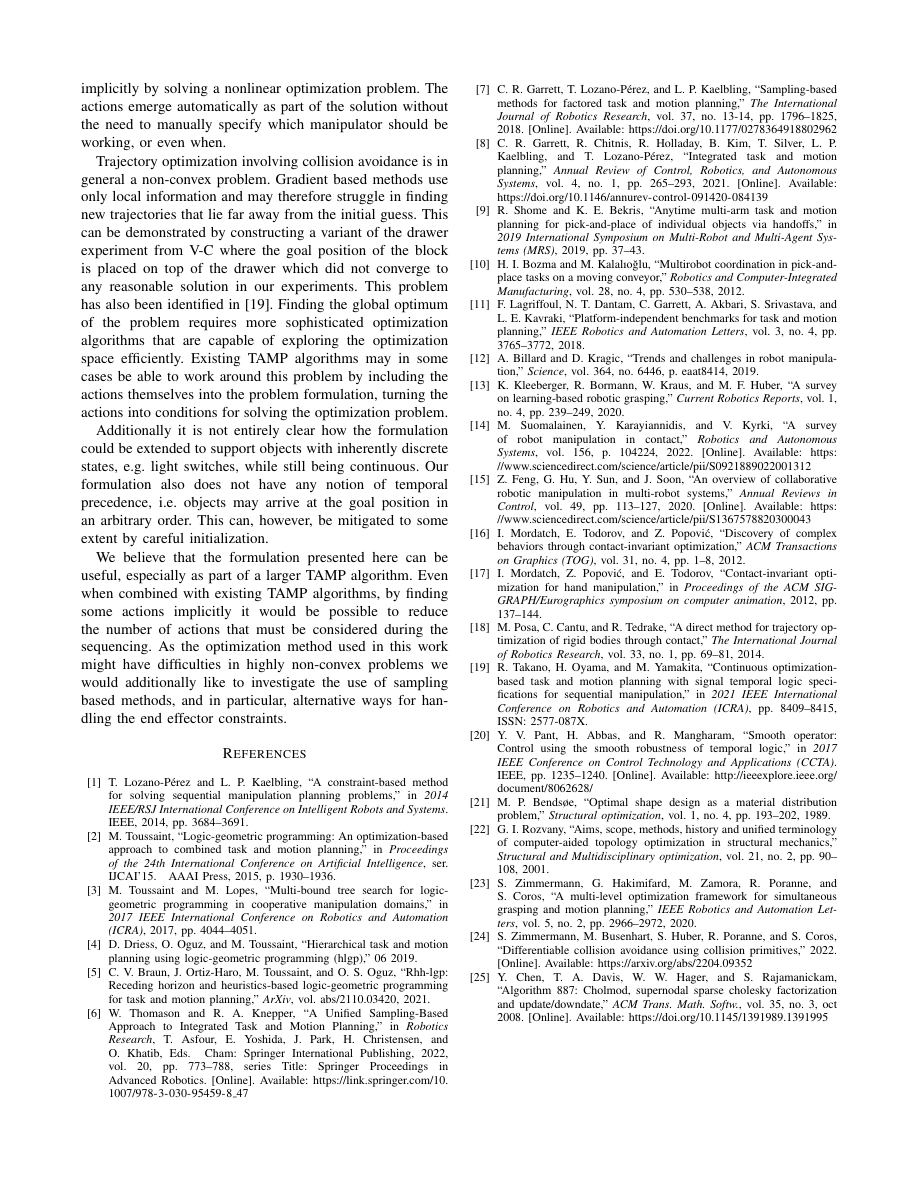

LLM query took 34.10 seconds to process!
(" The image you've provided appears to be a page from a document or article, "
 'which includes text and bullet points discussing an efficient motion '
 'planning algorithm for robotic manipulation.\n'
 '\n'
 'Here are the visible lines of text:\n'
 '\n'
 '- ...the need for effective robotics solutions has never been more '
 'critical.\n'
 '- ...efficiently address challenges in areas such as...\n'
 '- ...motion planning algorithms, which have been crucial in solving complex '
 'problems in various fields including robotics and automation.\n'
 '- ...focused on reducing motion, however, these traditional approaches may '
 'not always be suitable for robotic manipulation tasks.\n'
 '- ...requirement to move the object from a certain location to another '
 'location while also avoiding collisions with objects in the workspace.\n'
 "- ...the object's position and orientation in relation to its target "
 'position.\n'
 '- ...robots can efficiently n

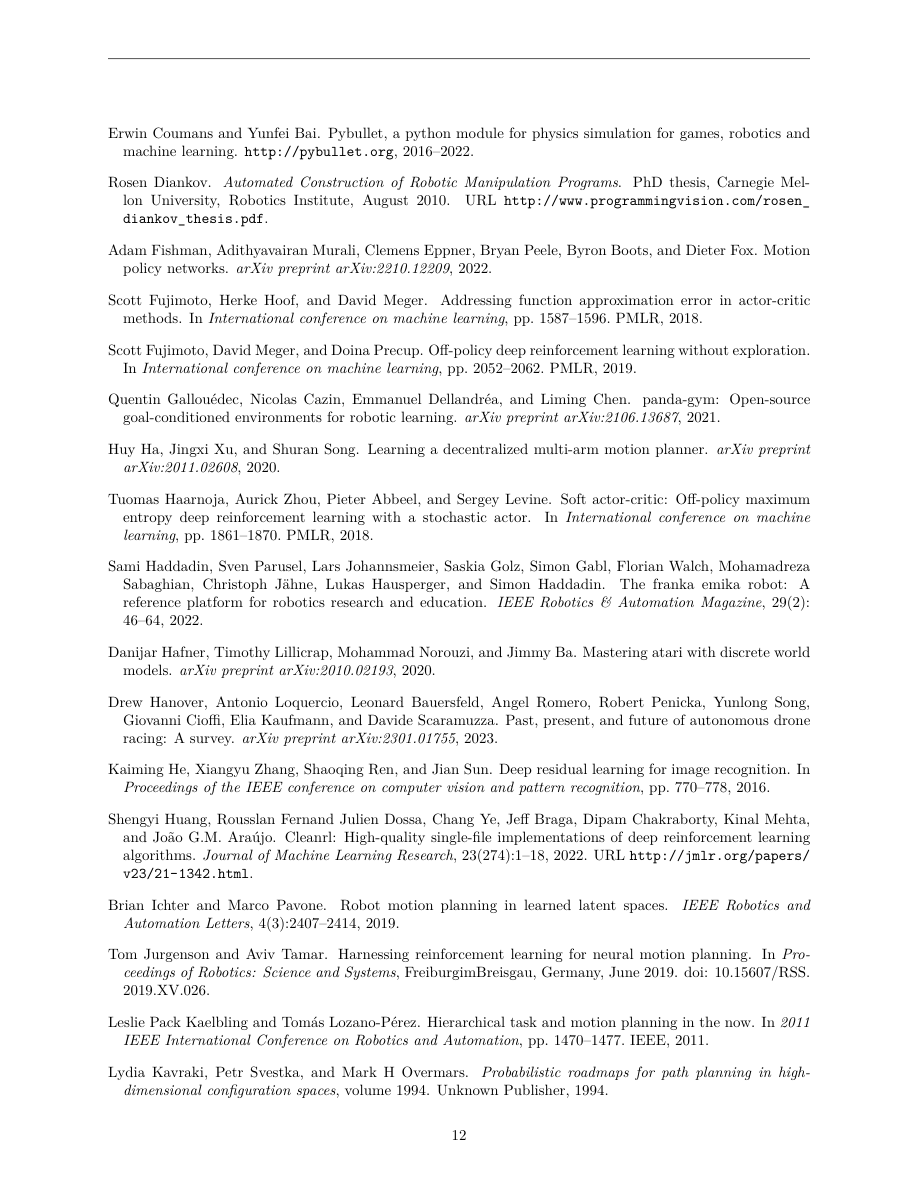

LLM query took 52.09 seconds to process!
(" The image you've provided appears to be a screenshot of a document or "
 'article with a title that mentions "efficient motion planning algorithm for '
 'robotic manipulation." The text within the document is too small to read '
 'clearly, but from the visible headings and bullet points, it seems to '
 'discuss various topics related to robotics and automation.\n'
 '\n'
 'Regarding your question on an efficient motion planning algorithm for '
 'robotic manipulation, such algorithms are critical for enabling robots to '
 'navigate their environment safely and effectively. These algorithms '
 "typically take into account factors like the robot's physical constraints "
 '(e.g., joint angles), workspace geometry (e.g., obstacles), task '
 'specifications (e.g., object to grasp), and environmental conditions (e.g., '
 'lighting).\n'
 '\n'
 'An efficient motion planning algorithm would ideally satisfy several key '
 'requirements:\n'
 '\n'
 '1. **O

In [18]:
deep_doc_ask( "Describe an efficient motion planning algorithm for robotic manipulation." )